Copyright 2021 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This colab showcases the usage of the Enformer model published in

**"Effective gene expression prediction from sequence by integrating long-range interactions"**

Žiga Avsec1*, Vikram Agarwal2,4, Daniel Visentin1,4, Joseph R. Ledsam1,3, Agnieszka Grabska-Barwinska1, Kyle R. Taylor1, Yannis Assael1, John Jumper1, Pushmeet Kohli1*, David R. Kelley2*

- 1 DeepMind, London, UK
- 2 Calico Life Sciences, South San Francisco, CA, USA
- 3 Google, Tokyo, Japan
- 4 These authors contributed equally.
- `*` correspondence: avsec@google.com, pushmeet@google.com, drk@calicolabs.com


**Note:** This colab will not yet work since the model isn't yet publicly available. We are working on enabling this and will update the colab accordingly.

### Steps

This colab demonstrates how to
- Make predictions with Enformer and reproduce Fig. 1d
- Compute contribution scores and reproduce parts of Fig. 2a
- Predict the effect of a genetic variant and reproduce parts of Fig. 3g
- Score multiple variants in a VCF 

## Setup

**Start the colab kernel with GPU**: Runtime -> Change runtime type -> GPU

In [ ]:
import tensorflow as tf
# Make sure the GPU is enabled 
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'

In [ ]:
!pip install kipoiseq --quiet > /dev/null

### Imports

In [ ]:
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
transform_base_path = 'dna_transformer_2020_1kG_SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_base_path = '13376309-3.finetuned'

transform_path = f'/root/models/{transform_base_path}'
model_path = f'/root/models/{model_base_path}'
fasta_file = '/root/data/genome.fa'

# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
clinvar_vcf = '/root/data/clinvar.vcf.gz'

In [ ]:
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


### Download files

In [ ]:
# Mount google drive. Models will be made available through https://www.tensorflow.org/hub
# and https://storage.googleapis.com/deepmind-enformer soon.
import os.path
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Download models
!mkdir -p /root/models/
models_dir = '/gdrive/My\ Drive/models/'
!cp -R {models_dir}/{transform_base_path} /root/models/
!cp -R {models_dir}/{model_base_path} /root/models/

Download and index the reference genome fasta file

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

In [ ]:

!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data

--2021-01-12 22:47:12--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  10.4MB/s    in 79s     

2021-01-12 22:48:31 (11.9 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


Download the clinvar file. Reference:

Landrum MJ, Lee JM, Benson M, Brown GR, Chao C, Chitipiralla S, Gu B, Hart J, Hoffman D, Jang W, Karapetyan K, Katz K, Liu C, Maddipatla Z, Malheiro A, McDaniel K, Ovetsky M, Riley G, Zhou G, Holmes JB, Kattman BL, Maglott DR. ClinVar: improving access to variant interpretations and supporting evidence. Nucleic Acids Res . 2018 Jan 4. PubMed PMID: 29165669 .


In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz -O /root/data/clinvar.vcf.gz

--2021-01-12 22:49:23--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 2607:f220:41e:250::10, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34090716 (33M) [application/x-gzip]
Saving to: ‘/root/data/clinvar.vcf.gz’

/root/data/clinvar. 100%[===================>]  32.51M  16.1MB/s    in 2.0s    

2021-01-12 22:49:25 (16.1 MB/s) - ‘/root/data/clinvar.vcf.gz’ saved [34090716/34090716]



### Code (double click on the title to show the code)

In [ ]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, saved_model_path):
    self._model = tf.saved_model.load(saved_model_path).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, saved_model_path, organism='human'):
    self._model = Enformer(saved_model_path)
    self._organism = organism
  
  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, saved_model_path, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(saved_model_path, organism)
    transform_pipeline = joblib.load(transform_pkl_path)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, saved_model_path, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(saved_model_path, organism)
    self._transform = joblib.load(transform_pkl_path)
    self._num_top_features = num_top_features
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

In [ ]:
# @title `variant_centered_sequences`

class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)
    
  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

In [ ]:
# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequenece

In [ ]:
model = Enformer(model_path)

fasta_extractor = FastaStringExtractor(fasta_file)

In [ ]:
# @title Make predictions for an genomic example interval
target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

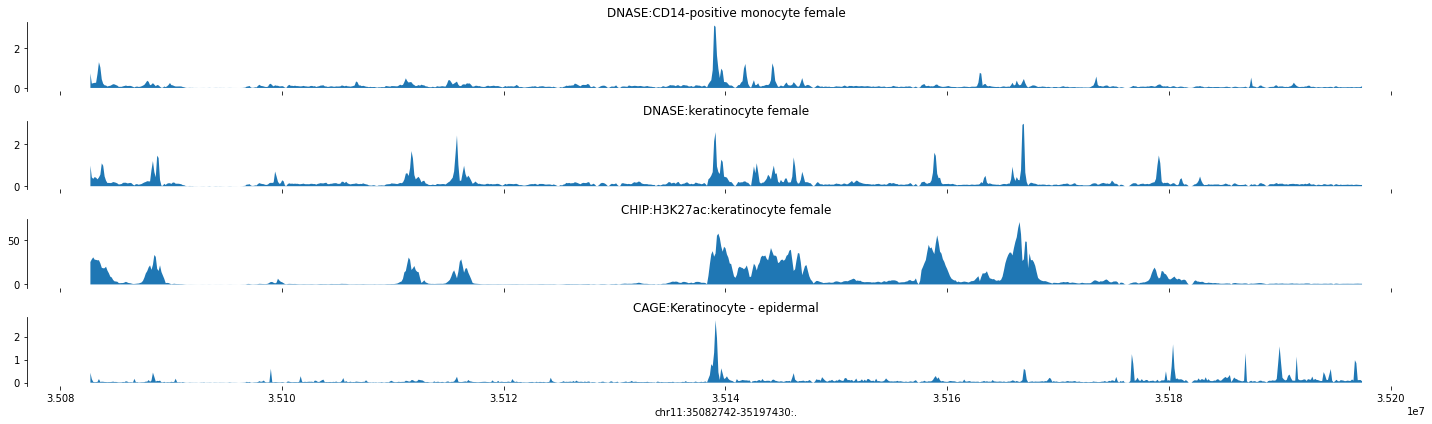

In [ ]:
# @title Plot tracks
tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799])}
plot_tracks(tracks, target_interval)

## Contribution scores example

In [ ]:
# @title Compute contribution scores
target_interval = kipoiseq.Interval('chr12', 54_223_589, 54_338_277)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

target_mask = np.zeros_like(predictions)
for idx in [447, 448, 449]:
  target_mask[idx, 4828] = 1
  target_mask[idx, 5111] = 1
# This will take some time since tf.function needs to get compiled.
contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]

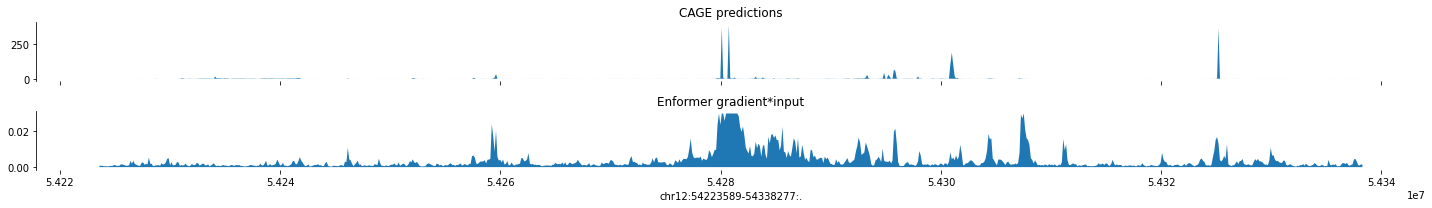

In [ ]:
tracks = {'CAGE predictions': predictions[:, 4828],
          'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
plot_tracks(tracks, target_interval);

## Variant scoring example

In [ ]:
# @title Score the variant
variant = kipoiseq.Variant('chr16', 57025062, 'C', 'T', id='rs11644125')  # @param

# Center the interval at the variant
interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start

reference = seq_extractor.extract(interval, [], anchor=center)
alternate = seq_extractor.extract(interval, [variant], anchor=center)

# Make predictions for the refernece and alternate allele
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]

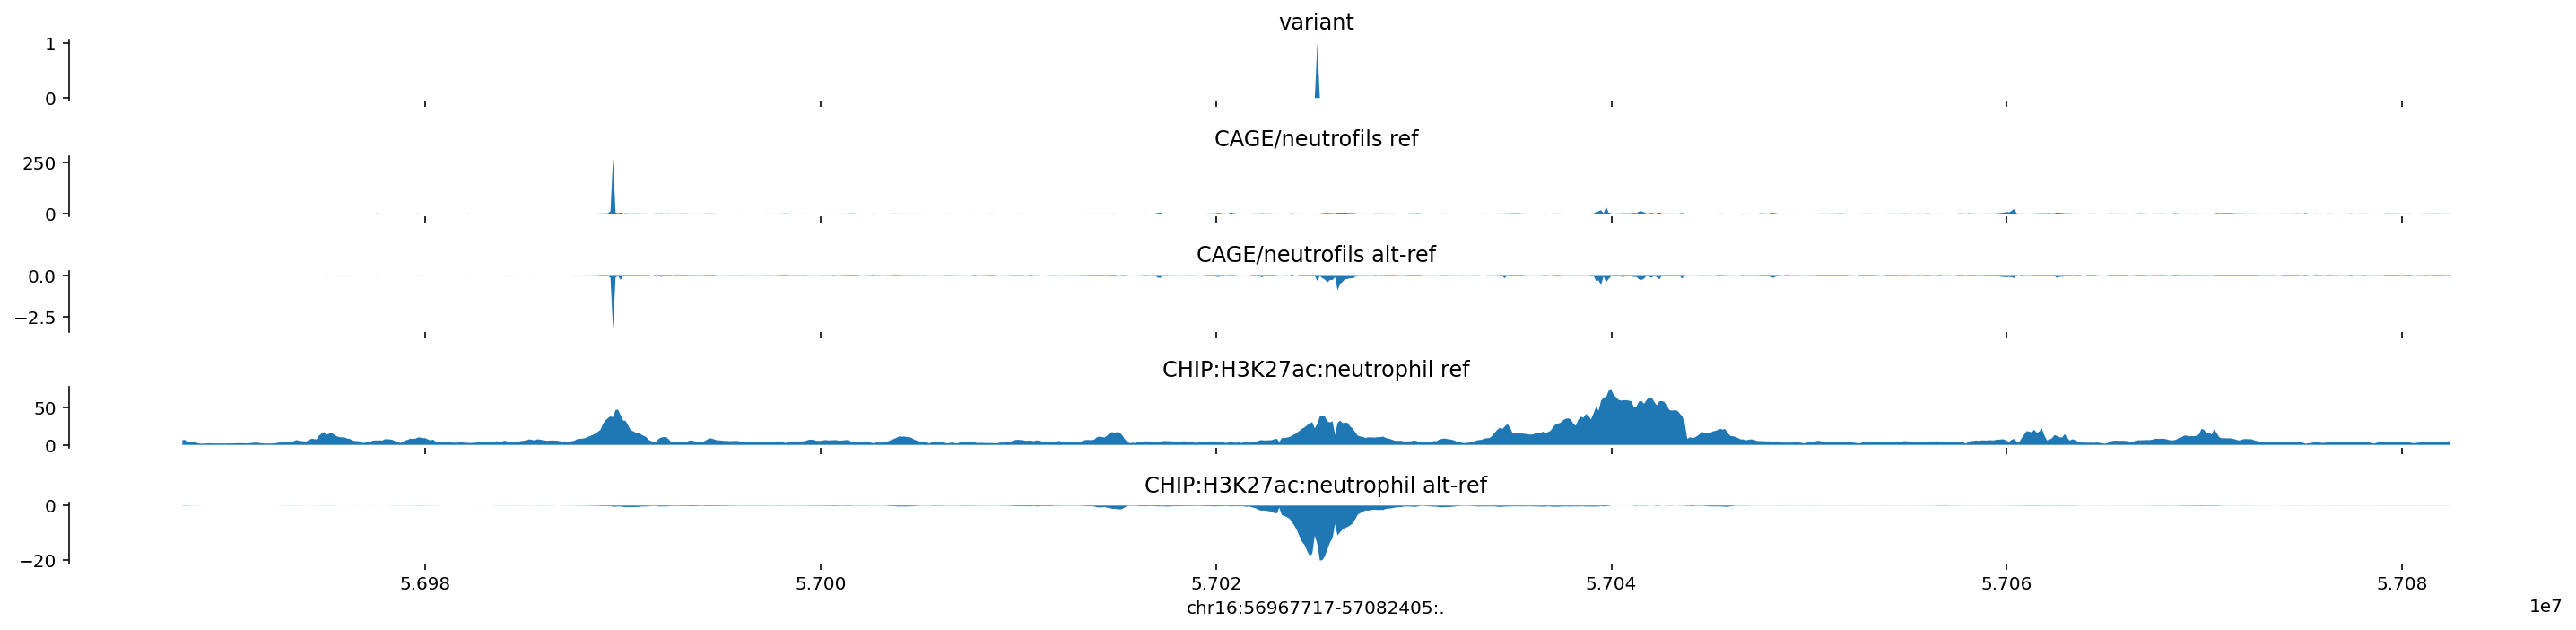

In [ ]:
# @title Visualize some tracks
variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True
tracks = {'variant': variant_track,
          'CAGE/neutrofils ref': reference_prediction[:, 4767],
          'CAGE/neutrofils alt-ref': alternate_prediction[:, 4767] - reference_prediction[:, 4767],
          'CHIP:H3K27ac:neutrophil ref': reference_prediction[:, 2280],
          'CHIP:H3K27ac:neutrophil alt-ref': alternate_prediction[:, 2280] - reference_prediction[:, 2280],
          }

plot_tracks(tracks, interval.resize(reference_prediction.shape[0] * 128), height=1)

## Score variants in a VCF file

### Report top 20 PCs

In [ ]:
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)

In [ ]:
# Score the first 5 variants from ClinVar
# Lower-dimensional scores (20 PCs)
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                 gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,chr1,930188,846933,G,A,-61.471287,-5.655146,-2.758397,6.290497,1.846261,3.449631,6.052878,0.634326,2.584449,1.118316,1.944067,-6.512556,-4.948595,-1.168765,-2.903484,0.484869,2.897006,1.758686,3.685951,-6.672137
1,chr1,930203,972363,C,T,21.482735,-9.249768,3.685621,9.606244,0.538989,5.262571,1.418416,-14.005647,12.897153,9.390783,-5.201140,-3.090504,1.975024,-5.241168,-14.366508,-7.802508,0.141153,12.087668,-5.559410,9.170748
2,chr1,930248,789256,G,A,0.498874,1.982327,-2.750614,-3.141907,-5.241604,-4.961285,-1.702641,2.543528,-2.248600,-0.774210,-0.368460,-1.392373,-6.709529,0.173268,6.361717,3.989930,1.602195,-5.265455,0.852734,-0.946416
3,chr1,930275,969662,T,G,-3.028966,2.984429,7.532916,6.588795,19.307785,5.661951,0.962246,5.863384,-6.041630,2.309155,9.062576,1.426052,-3.792181,3.136441,-2.617620,0.942220,-6.195234,-6.291888,-5.329431,-1.141422
4,chr1,930336,843786,G,A,-45.674007,-6.556405,-0.550849,16.986986,-5.257315,5.071064,6.669114,-1.328647,-9.566864,11.220359,3.839488,-8.214136,-4.864720,-2.947721,-13.659990,1.405919,-3.936957,10.316927,1.663230,-5.247654


### Report all 5,313 features (z-score normalized)

In [ ]:
enformer_score_variants_all = EnformerScoreVariantsNormalized(model_path, transform_path)

In [ ]:
# Score the first 5 variants from ClinVar
# All Scores
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                 gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants_all.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {name[:20]: score for name, score in zip(df_targets.description, variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,DNASE:cerebellum mal,DNASE:frontal cortex,DNASE:chorion,DNASE:Ishikawa treat,DNASE:GM03348,DNASE:GM03348 geneti,DNASE:AG08395,DNASE:AG08396,DNASE:AG20443,DNASE:H54,DNASE:GM10248,DNASE:GM12878,DNASE:GM12891,DNASE:GM12892,DNASE:GM18507,DNASE:GM19238,DNASE:GM19239,DNASE:GM19240,DNASE:H1-hESC,DNASE:H7-hESC,DNASE:H9,DNASE:heart male adu,DNASE:HEK293T,DNASE:HeLa-S3 treate,DNASE:HeLa-S3,DNASE:hepatocyte,DNASE:HepG2,DNASE:HTR-8/SVneo,DNASE:endothelial ce,DNASE:CWRU1 male,DNASE:iPS-NIHi11 mal,DNASE:iPS-NIHi7 fema,DNASE:K562 treated w,DNASE:K562 G2 phase,DNASE:K562 G1 phase,...,CAGE:CD14+CD16- Mono,CAGE:achilles tendon,CAGE:cerebrospinal f,CAGE:cruciate ligame,CAGE:eye - vitreous,CAGE:eye - muscle su,CAGE:eye - muscle la,CAGE:eye - muscle me,CAGE:eye - muscle in,CAGE:Fingernail (inc,"CAGE:optic nerve,","CAGE:Skin - palm,",CAGE:tongue epidermi,"CAGE:Urethra,",CAGE:CD14+ monocytes,CAGE:Hep-2 cells tre,CAGE:Hep-2 cells moc,CAGE:immature langer,CAGE:migratory lange,CAGE:CD34 cells diff,CAGE:amygdala - adul,CAGE:thalamus - adul,CAGE:hippocampus - a,CAGE:parietal lobe -,CAGE:cerebellum - ad,CAGE:pineal gland -,CAGE:spinal cord - a,CAGE:Olfactory epith,CAGE:gamma delta pos,"CAGE:Mast cell, expa","CAGE:adipose,","CAGE:cerebellum, new","CAGE:spinal cord, ne","CAGE:amygdala, newbo","CAGE:hippocampus, ne","CAGE:putamen, newbor","CAGE:thalamus, newbo",CAGE:thymic carcinom,CAGE:Smooth muscle c,CAGE:parietal cortex
0,chr1,930188,846933,G,A,-1.786843,-15.682123,-22.520702,0.528606,-3.829948,-3.232739,-2.671064,-9.467652,-3.155200,-7.706491,-3.149441,-0.523933,-11.134032,-11.109153,-3.670341,-8.464477,-11.757355,-8.598063,-0.531494,0.225998,-0.777080,-15.741483,0.879350,-6.576440,-4.204203,-8.632437,-0.466419,-3.439260,-0.311319,-4.804222,-5.151290,-1.418189,0.366935,-2.001119,-2.294838,...,-33.057209,-2.997374,-8.419192,-5.191596,-4.536147,-5.455176,-3.037405,-7.164758,-2.292249,-8.986766,-4.790454,-4.795162,-1.450022,-1.989321,-22.918665,-35.752350,-35.278088,-13.375848,-28.361494,-31.598894,-11.373973,-9.255016,-9.010527,-9.231528,-3.780572,-0.282759,-12.095373,-59.163910,-66.295670,-34.482758,-21.271309,-4.326236,-16.074772,-6.284147,-10.391891,-6.422609,-9.180881,-14.222376,-46.489288,-11.498157
1,chr1,930203,972363,C,T,3.888234,-0.792556,-1.675466,4.746172,1.695362,2.216201,-0.281044,-1.136617,0.372290,-3.771606,3.466754,1.097348,2.531235,5.103032,1.873044,3.959806,1.216984,3.810981,0.649070,2.553843,0.989534,1.633624,5.512297,-6.207155,-13.487192,6.362380,0.166047,-4.554312,-0.160736,-1.996482,-2.641517,0.414536,7.214015,4.067241,2.957357,...,33.842506,-0.583508,0.268065,-3.203938,5.382962,1.292423,0.993049,2.095632,-0.293384,4.008999,-0.025227,-0.550521,-1.000858,0.568729,27.443323,-22.869347,-32.034206,12.032639,15.752299,19.407349,2.799562,3.406885,1.643052,2.385034,-1.272377,35.168621,-0.531365,-15.452000,42.711445,22.988682,-2.011288,1.716742,1.979876,5.205636,6.388551,3.159813,0.636698,-0.784998,-4.407548,3.055573
2,chr1,930248,789256,G,A,-3.392124,-6.586333,-6.679351,-0.481332,0.732646,1.129496,1.167766,-1.667323,0.800817,-4.803396,-0.813693,0.774903,-2.916472,-3.757783,0.205903,-2.631254,-2.177644,-5.314756,-1.064787,-4.775336,-0.307169,-9.369971,-4.574942,-1.763874,4.670806,-9.955566,2.540043,-0.725449,-0.909228,-2.151628,-1.621970,0.037685,-6.617916,-4.519673,-3.751483,...,-3.718003,-0.702731,3.008476,0.761387,-3.265729,1.070971,-0.497848,0.965013,0.367486,-1.758073,0.375682,-0.949173,-1.022737,0.486035,-0.185559,56.499584,67.082275,1.473261,-0.636782,-0.981452,-0.348060,0.946137,0.874985,0.469065,-3.461762,-21.804483,1.403917,-1.323191,0.396306,-5.381416,4.841636,0.019535,2.721695,-1.743816,-1.392196,1.243525,-1.840826,-0.622136,6.409196,-0.923778
3,chr1,930275,969662,T,G,3.287432,-1.920073,5.813212,2.442116,3.727493,3.496869,0.895325,2.030542,4.058121,-1.889122,1.946017,-1.543661,9.562781,8.657282,1.719417,1.913109,7.135823,3.970765,0.610678,3.715666,0.340136,-12.232494,5.522506,7.254625,7.424074,-1.945692,1.009